---
---
# Лабораторная работа №3. Анализ социальных сетей. Кластеризация фотографий со стены Вконтакте

---
---
# Массовое скачивание фотографий из групп ВКонтакте с использованием API

In [1]:
import os
from re import split
from time import sleep
from datetime import datetime
import vk
import requests

## Настройки программы
- public_link - полная ссылка на группу или паблик
- album_id - id альбома ('wall' - стена сообщества)
- rev - порядок загрузки (0 - хронологический, 1 - антихронологический)
- start_offset - с какой по счету фотографии начать загрузку
- phs_num - сколько фотографий нужно загрузить
- download_dir_name - путь к директории загрузки (если пустая строка, то файлы сохранятся в папке с кратким названием сообщества)

In [27]:
public_link = 'https://vk.com/ardezart'
album_id = 'wall'
rev = 0
start_offset = 0
phs_num = 50
download_dir_name = r'D:/IMG/'
token = ''

### Авторизируемся в ВК

In [19]:
session = vk.Session(access_token=token)
vk_api = vk.API(session)

### Получаем id сообщества

In [28]:
public_name = split(r'/', public_link)[-1]
if download_dir_name == '':
    download_dir_name = public_name
public_data = vk_api.groups.getById(group_id=public_name, v=5.102)
public_id = public_data[0]['id']
public_data

[{'id': 40131273,
  'name': 'Архитектура Ardezart',
  'screen_name': 'ardezart',
  'is_closed': 0,
  'type': 'page',
  'is_admin': 0,
  'is_member': 0,
  'is_advertiser': 0,
  'photo_50': 'https://sun7-14.userapi.com/s/v1/ig2/-xoBaK7Tr3S5vbSIXOXGKkpdfizgqmb0ICJWF3ssTvZegnII6NHcY9TLMDi0X-SkUdDRwCQGrIrG-d9WMN6GZBgA.jpg?size=50x50&quality=96&crop=30,61,956,956&ava=1',
  'photo_100': 'https://sun7-14.userapi.com/s/v1/ig2/2_cRC8IofWEFNKQy9S9e3It6_AqUyh3V0epI4tE_ZAj69lTCfTVyuqxsHXG45MthuiQ0On2FJ1oekVcWYYy2gNPm.jpg?size=100x100&quality=96&crop=30,61,956,956&ava=1',
  'photo_200': 'https://sun7-14.userapi.com/s/v1/ig2/ztCuYkX9OnX933vBzTXUtowyNi1VORYvGiYDwivLM64_r6TyOgQ700xPvOLT7CdSvHCJl7cJbmv4NsorSV60TAzJ.jpg?size=200x200&quality=96&crop=30,61,956,956&ava=1'}]

### При помощи API получаем список URL изображений и записываем в файл
API не разрешает получать ссылки более чем на тысячу фотографий за один раз, поэтому программа сделает несколько запросов.

In [29]:
photo_links = []
offset = start_offset
now = datetime.now().strftime('%d-%m-%Y-%H-%M')

remain_num = phs_num
for i in range(int(phs_num / 1000) + 1):
    if remain_num >= 1000:
        download_num = 1000
    else:
        download_num = remain_num
    remain_num -= download_num
    wall_phs = vk_api.photos.get(owner_id=-public_id,
                                 album_id=album_id,
                                 v=5.102,
                                 count=download_num,
                                 offset=offset,
                                 rev=rev)
    for photo in wall_phs['items']:
        photo_links.append(photo['sizes'][-1]['url'])
    offset += download_num
    
with open(f'dump_{public_id}_{album_id}_{start_offset}_{phs_num}_{now}.txt', 'w') as file:
    file.writelines('%s\n' % link for link in photo_links)

### Загружаем фотографии
За счёт хранения ссылок в файле можно будет возобновлять загрузку после прерывания - ранее скачанные файлы в данную директорию загружаться не будут. Для перезапуска процесса скачивания после повторного открытия Jupyter-ноутбука нужно **указать вручную путь к файлу с URL**.

In [30]:
url_filename = f'dump_{public_id}_{album_id}_{start_offset}_{phs_num}_{now}.txt'
with open(url_filename, 'r') as file:
    photo_links = file.read().splitlines()

if not os.path.exists(download_dir_name):
    os.makedirs(download_dir_name)

ld = os.listdir(download_dir_name)
counter = 0
for link in photo_links:
    counter += 1
    name = str(counter) + '.jpg'
    ce = True
    filename = split('/', link)[-1]
    if filename not in ld:
        while ce:
            try:
                img_data = requests.get(link).content
                ce = False
            except requests.exceptions.ConnectionError:
                sleep(5)
        with open(os.path.join(download_dir_name, name), 'wb') as handler:
            handler.write(img_data)

### Проверим результат

In [31]:
print(f'В директории "{download_dir_name}" {len(os.listdir(download_dir_name))} файлов')

В директории "D:/IMG/" 50 файлов


---
---
## Кластеризация цветов на изображении

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import numpy as np

from sklearn.cluster import KMeans

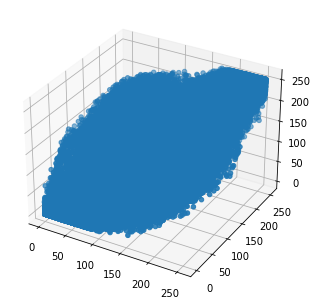

In [38]:
#read image
img = cv2.imread('D:/IMG/1.jpg')
#convert from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#get rgb values from image to 1D array
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()
#plotting
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

In [39]:
class DominantColors:

  CLUSTERS = None
  IMAGE = None
  COLORS = None
  LABELS = None

  def __init__(self, image, clusters=3):
    self.CLUSTERS = clusters
    self.IMAGE = image

  def dominantColors(self):
    #read image
    img = cv2.imread(self.IMAGE)
    #convert to rgb from bgr
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #reshaping to a list of pixels
    img = img.reshape((img.shape[0] *
    img.shape[1], 3))
    #save image after operations
    self.IMAGE = img
    #using k-means to cluster pixels
    kmeans = KMeans(n_clusters = self.CLUSTERS)
    kmeans.fit(img)
    #the cluster centers are our dominant colors.
    self.COLORS = kmeans.cluster_centers_
    #save labels
    self.LABELS = kmeans.labels_
    return self.COLORS.astype(int)

  def plotHistogram(self):
      #labels form 0 to no. of clusters
      numLabels = np.arange(0, self.CLUSTERS+1)
      #create frequency count tables
      (hist, _) = np.histogram(self.LABELS, bins
      = numLabels)
      hist = hist.astype("float")
      hist /= hist.sum()
      #appending frequencies to cluster centers
      colors = self.COLORS
      #descending order sorting as per frequency
      colors = colors[(-hist).argsort()]
      hist = hist[(-hist).argsort()]
      #creating empty chart
      chart = np.zeros((50, 500, 3), np.uint8)
      start = 0
      #creating color rectangles
      for i in range(self.CLUSTERS):
        end = start + hist[i] * 500
        #getting rgb values
        r = colors[i][0]
        g = colors[i][1]
        b = colors[i][2]
        #using cv2.rectangle to plot colors
        cv2.rectangle(chart, (int(start), 0),
        (int(end), 50), (r,g,b), -1)
        start = end
      #display chart
      plt.figure()
      plt.axis("off")
      plt.imshow(chart)
      plt.show()

In [43]:
img = 'D:/IMG/1.jpg'
clusters = 5
dc = DominantColors(img, clusters)
colors = dc.dominantColors()
print(colors)

[[ 92 120 146]
 [120  79  75]
 [159 143 137]
 [195 202 202]
 [ 49  33  35]]


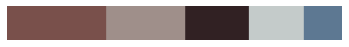

In [44]:
dc.plotHistogram()

---
---
## Кластеризация изображений на основе доминирующих цветов

In [45]:
directory = 'D:/IMG'
filenames = []
data = []
for num, filename in enumerate(os.listdir(directory)):
  data_iter = []
  filenames.append(filename)
  img = str(directory) + '/' + filename
  #print (img)
  clusters = 2
  dc = DominantColors(img, clusters)
  colors = dc.dominantColors()
  for i in colors:
    for j in i:
      data_iter.append(j)
    data.append(data_iter)
  print(colors)

[[164 163 164]
 [ 92  65  65]]
[[ 67  63  63]
 [202 197 195]]
[[ 75  78  71]
 [150 165 179]]
[[ 77  80  81]
 [183 179 166]]
[[164 161 160]
 [ 67  89 143]]
[[ 85  60  48]
 [159 147 132]]
[[156 163 173]
 [ 79  77  79]]
[[ 94 144 192]
 [ 16  28  60]]
[[ 79  97 125]
 [193 184 167]]
[[ 56  63  67]
 [143 148 157]]
[[ 81  86  95]
 [146 155 178]]
[[203 201 197]
 [ 89  62  47]]
[[199 199 195]
 [ 56  56  48]]
[[175 176 175]
 [ 57  59  58]]
[[ 71  66  60]
 [190 190 184]]
[[248 248 247]
 [122 122 117]]
[[251 251 251]
 [100 100  99]]
[[242 242 244]
 [ 58  61  58]]
[[192 199 208]
 [ 65  62  57]]
[[199 205 214]
 [ 55  55  50]]
[[179 189 200]
 [ 56  56  55]]
[[ 64  62  63]
 [169 172 190]]
[[ 59  73  81]
 [207 216 219]]
[[ 48  48  48]
 [199 200 206]]
[[247 247 247]
 [133 135 135]]
[[147 149 149]
 [248 248 248]]
[[254 254 254]
 [ 61  60  60]]
[[254 254 254]
 [ 60  59  60]]
[[ 95  76  59]
 [201 206 215]]
[[124  82  64]
 [151 166 206]]
[[ 75  71  63]
 [192 194 204]]
[[110  76  53]
 [201 190 177]]
[[ 94  7

In [46]:
np_data = np.asarray(data, dtype=np.float32)

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
XPCAreduced = pca.fit_transform(np_data)
print (XPCAreduced)
print(filenames)
xs, ys, zs = np_data[:, 0], np_data[:, 1], np_data[:,2]

[[ 1.17801811e+02 -6.54682007e+01  1.22529850e+01]
 [ 1.17802216e+02 -6.54681854e+01  1.22528610e+01]
 [-1.52269470e+02 -1.39463034e+01 -3.67008615e+00]
 [-1.52269501e+02 -1.39462481e+01 -3.67010951e+00]
 [-1.01794159e+02 -4.66216240e+01 -3.03364962e-01]
 [-1.01794167e+02 -4.66215935e+01 -3.03377807e-01]
 [-1.07595383e+02 -2.63531322e+01 -4.25933313e+00]
 [-1.07595383e+02 -2.63531322e+01 -4.25933313e+00]
 [ 8.54094086e+01 -3.64872131e+01 -2.31824875e+00]
 [ 8.54094086e+01 -3.64872131e+01 -2.31824875e+00]
 [-9.48549805e+01 -7.82593307e+01  3.22065315e+01]
 [-9.48549805e+01 -7.82593307e+01  3.22065315e+01]
 [ 1.13556999e+02 -6.16877480e+01 -3.34249187e+00]
 [ 1.13556999e+02 -6.16877480e+01 -3.34249187e+00]
 [ 1.36434677e+02 -1.50486969e+02 -5.03868370e+01]
 [ 1.36434677e+02 -1.50486969e+02 -5.03868370e+01]
 [-8.46199722e+01 -1.23594977e-01 -3.63789368e+01]
 [-8.46199722e+01 -1.23594977e-01 -3.63789368e+01]
 [-1.00929848e+02 -8.18929672e+01 -4.26657534e+00]
 [-1.00929848e+02 -8.18929672e+

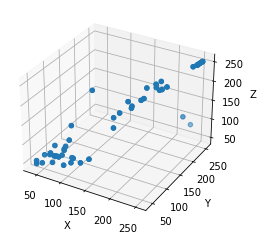

In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()